In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     |████████████████▎               | 834.1 MB 1.3 MB/s eta 0:10:00tcmalloc: large alloc 1147494400 bytes == 0x39000000 @  0x7f9df7caa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████▋           | 1055.7 MB 1.2 MB/s eta 0:07:54tcmalloc: large alloc 1434370048 bytes == 0x7d656000 @  0x7f9df7caa615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |██████████████████████████▏     | 

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e,'error')

1 Physical GPUs, 1 Logical GPU


In [ ]:
import torch
from typing import Optional, Callable, Union, Dict, Tuple
from tqdm import tqdm
import os


class Trainer:
    """
    This is the default class for defining trainers to teach neural networks
    different tasks.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to train.
    optimiser : torch.optim.Optimizer
        The optimiser to use during training.
    loss_fn : Callable
        The loss function to use during training.
    no_of_epochs : int
        The number of epochs to train for.
    batch_size : int
        The batch size to use.
    data_pth : str
        The path to the training/validation data.
    save_dir : str, optional
        The directory to save the trained models to. Default is ``"./"`` -- the
        :abbr:`CWD (current working directory)`.
    scheduler : torch.optim.lr_scheduler._LRScheduler, optional
        The way to adaptively change the learning rate while training. Default
        is None. For examples on how to adaptively change the learning rate
        please see
        `here <https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate>`_.
    device_id : int or str, optional
        Which device to perform training on. Providing an integer will point to
        the GPU with that specific ID whereas the string option can be used to
        also specify training on the CPU. When using ``nn.DataParallel`` for the
        model, setting ``device_id = "cuda"`` uses all GPUs. Default is 0 -- use
        the GPU corresponding to ID ``"cuda:0"``.
    data_parallel : bool, optional
        Whether or not to use multiple GPUs for training. Default is ``False``.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        optimiser: torch.optim.Optimizer,
        loss_fn: Callable[[torch.tensor, torch.tensor], torch.tensor],
        no_of_epochs: int,
        batch_size: int,
        data_pth: str,
        save_dir: str = "./",
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
        device_id: Union[int, str] = 0,
        data_parallel: bool = False,
    ) -> None:

        self.device = torch.device(
            f"cuda:{device_id}" if type(device_id) == int else device_id
        )

        if data_parallel:
            self.model = torch.nn.DataParallel(model)
        else:
            self.model = model
        self.model.to(self.device)

        self.optimiser = optimiser

        self.loss_fn = loss_fn

        self.total_epochs = no_of_epochs
        self.batch_size = batch_size

        self.data_pth = data_pth

        self.save_dir = save_dir

        self.scheduler = scheduler

        self.current_epoch = 0

    def load_data(self) -> None:
        """
        User-defined data loading instance method.
        This should populate self.train_in, self.train_out, self.val_in and self.val_out.
        """

        raise NotImplementedError("This must be user-defined!!")

    def checkpoint(self, add_info: Optional[Dict] = None) -> None:
        """
        This class method creates a checkpoint for the current epoch.

        Parameters
        ----------
        add_info : dict, optional
            An additional information to add to the checkpoint e.g. scheduler
            state dictionary. Default is ``None``.
        """

        if isinstance(self.model, torch.nn.DataParallel):
            self.chkpt = {
                "epoch": self.current_epoch,
                "model_state_dict": self.model.module.state_dict(),
                "optimiser_state_dict": self.optimiser.state_dict(),
                "train_losses": self.train_losses,
                "val_losses": self.val_losses,
            }
        else:
            self.chkpt = {
                "epoch": self.current_epoch,
                "model_state_dict": self.model.state_dict(),
                "optimiser_state_dict": self.optimiser.state_dict(),
                "train_losses": self.train_losses,
                "val_losses": self.val_losses,
            }

        if isinstance(add_info, dict):
            self.chkpt.update(add_info)

    def save_checkpoint(self, custom_path: Optional[str] = None) -> None:
        """
        This class method saves the current checkpoint to the save directory
        defined when instantiating the class.

        Parameters
        ----------
        custom_path : str, optional
            Path to save the model to. Default is ``None``.
        """

        if isinstance(custom_path, str):
            save_pth = f"{custom_path}{self.current_epoch}.pth"
        else:
            save_pth = f"{self.save_dir}{self.current_epoch}.pth"

        if not hasattr(self, "chkpt"):
            self.checkpoint()
        torch.save(self.chkpt, save_pth)

    def load_checkpoint(self, filename: str) -> None:
        """
        This class method loads a checkpoint for the model.

        Parameters
        ----------
        filename : str
            The path to the model to load.
        """

        if os.path.isfile(filename):
            print(f"=> loading checkpoint at {filename}")
            chkpt = torch.load(filename)
            self.current_epoch = chkpt["epoch"]
            self.train_losses = chkpt["train_losses"]
            self.val_losses = chkpt["val_losses"]
            self.model.load_state_dict(chkpt["model_state_dict"])
            self.optimiser.load_state_dict(chkpt["optimiser_state_dict"])

            def_keys = [
                "epoch",
                "train_losses",
                "val_losses",
                "model_state_dict",
                "optimiser_state_dict",
            ]
            if len(chkpt.keys()) != 5:
                self.add_info = {}
                for key in chkpt.keys():
                    if key not in def_keys:
                        self.add_info.update({key: chkpt[key]})
            if self.scheduler:
                self.scheduler.load_state_dict(self.add_info["scheduler_state_dict"])

            train_l = self.train_losses[-1]
            val_l = self.val_losses[-1]
            print(
                f"=> loaded checkpoint at {filename} at epoch {self.current_epoch} with training loss {train_l} and validation loss {val_l}."
            )
        else:
            print(f"=> no checkpoint found at {filename}")


class ClassifierTrainer(Trainer):
    """
    A trainer for training a neural network for classification.

    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to train.
    optimiser : torch.optim.Optimizer
        The optimiser to use during training.
    loss_fn : Callable
        The loss function to use during training.
    no_of_epochs : int
        The number of epochs to train for.
    batch_size : int
        The batch size to use.
    data_pth : str
        The path to the training/validation data.
    save_dir : str, optional
        The directory to save the trained models to. Default is ``"./"`` -- the
        :abbr:`CWD (current working directory)`.
    scheduler : torch.optim.lr_scheduler._LRScheduler, optional
        The way to adaptively change the learning rate while training. Default
        is None. For examples on how to adaptively change the learning rate
        please see
        `here <https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate>`_.
    device_id : int or str, optional
        Which device to perform training on. Providing an integer will point to
        the GPU with that specific ID whereas the string option can be used to
        also specify training on the CPU. When using ``nn.DataParallel`` for the
        model, setting ``device_id = "cuda"`` uses all GPUs. Default is 0 -- use
        the GPU corresponding to ID ``"cuda:0"``.
    data_parallel : bool, optional
        Whether or not to use multiple GPUs for training. Default is ``False``.
    """

    def train(self, train_loader: torch.utils.data.DataLoader) -> Tuple[float, float]:
        """
        The function used to train the classifier model.

        Parameters
        ----------
        train_loader: torch.utils.data.DataLoader
            The data to train the model on wrapped up in a `PyTorch DataLoader
            <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_.

        Returns
        -------
         : float
            The average of the batch losses for one training epoch.
         : float
            The percentage correct on the training data.
        """
        self.model.train()

        batch_losses = []
        total, correct = 0.0, 0.0
        for j, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.float().to(self.device), labels.long().to(
                self.device
            )

            self.optimiser.zero_grad()
            output = self.model(images)
            loss = self.loss_fn(output, labels)
            loss.backward()
            self.optimiser.step()

            batch_losses.append(loss.item())

            # work out the % correct per epoch accumulatively
            _, predicted = torch.max(
                output.data, 1
            )  # output will have dimensions (batch_size, output_features) with the maximum taken along the output_features axis i.e. the probability distribution of classes, predicted is populated by the indices of the maximum in this dimension -- the class label.
            total += labels.size(0)
            correct += (
                predicted == labels
            ).sum()  # produces a boolean tensor which when summed evaluates True to 1 and False to 0.

        return torch.mean(torch.tensor(batch_losses)), float((correct / total) * 100)

    def validation(
        self, val_loader: torch.utils.data.DataLoader
    ) -> Tuple[float, float]:
        """
        The function used to validate the classifier model.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            The data to validate the model on wrapped up in a `PyTorch
            DataLoader
            <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_.

        Returns
        -------
         : float
            The average of the batch losses for one training epoch.
         : float
            The percentage correct on the validation data.
        """
        self.model.eval()

        total, correct = 0.0, 0.0
        with torch.no_grad():
            batch_losses = []
            for images, labels in val_loader:
                images, labels = images.float().to(self.device), labels.long().to(
                    self.device
                )
                output = self.model(images)
                _, predicted = torch.max(output.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()

                loss = self.loss_fn(output, labels)
                batch_losses.append(loss.item())

        return torch.mean(torch.tensor(batch_losses)), float((correct / total) * 100)


class RegressorTrainer(Trainer):
    """
    A trainer for training a neural network for regression.


    Parameters
    ----------
    model : torch.nn.Module
        The neural network model to train.
    optimiser : torch.optim.Optimizer
        The optimiser to use during training.
    loss_fn : Callable
        The loss function to use during training.
    no_of_epochs : int
        The number of epochs to train for.
    batch_size : int
        The batch size to use.
    data_pth : str
        The path to the training/validation data.
    save_dir : str, optional
        The directory to save the trained models to. Default is ``"./"`` -- the
        :abbr:`CWD (current working directory)`.
    scheduler : torch.optim.lr_scheduler._LRScheduler, optional
        The way to adaptively change the learning rate while training. Default
        is None. For examples on how to adaptively change the learning rate
        please see
        `here <https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate>`_.
    device_id : int or str, optional
        Which device to perform training on. Providing an integer will point to
        the GPU with that specific ID whereas the string option can be used to
        also specify training on the CPU. When using ``nn.DataParallel`` for the
        model, setting ``device_id = "cuda"`` uses all GPUs. Default is 0 -- use
        the GPU corresponding to ID ``"cuda:0"``.
    data_parallel : bool, optional
        Whether or not to use multiple GPUs for training. Default is ``False``.
    """

    def train(self, train_loader: torch.utils.data.DataLoader) -> float:
        """
        The function used to train the regression model.

        Parameters
        ----------
        train_loader: torch.utils.data.DataLoader
            The data to train the model on wrapped up in a `PyTorch DataLoader
            <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_.

        Returns
        -------
         : float
            The average of the batch losses for one training epoch.
        """
        self.model.train()

        batch_losses = []
        for j, (inputs, outputs) in enumerate(tqdm(train_loader)):
            inputs, outputs = inputs.float().to(self.device), outputs.float().to(
                self.device
            )

            self.optimiser.zero_grad()
            model_outputs = self.model(inputs)
            loss = self.loss_fn(model_outputs, outputs)
            loss.backward()
            self.optimiser.step()

            batch_losses.append(loss.item())

        return torch.mean(torch.tensor(batch_losses))

    def validation(self, val_loader: torch.utils.data.DataLoader) -> float:
        """
        The function used to validate the regression model.

        Parameters
        ----------
        val_loader : torch.utils.data.DataLoader
            The data to validate the model on wrapped up in a `PyTorch
            DataLoader
            <https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader>`_.

        Returns
        -------
         : float
            The average of the batch losses for one training epoch.
        """
        self.model.eval()

        batch_losses = []
        with torch.no_grad():
            for inputs, outputs in val_loader:
                inputs, outputs = inputs.float().to(self.device), outputs.float().to(
                    self.device
                )
                model_outputs = self.model(inputs)
                loss = self.loss_fn(model_outputs, outputs)

                batch_losses.append(loss.item())

        return torch.mean(torch.tensor(batch_losses))


# Training a PyTorch Classifier

The following notebook aims to show how to train a classification deep neural network from one of the "off the shelf" models that come as part of the ``torchvision`` module &mdash; specifically the model is known as the ``ResNet18`` model which means it is a residual neural network with 18 layers (details of this are unimportant but it is an adept network for image classification).

This will also be trained on the MNIST dataset &mdash; this is just a database of handwritten digits that is used in a lot of deep learning papers, it essentially classifies handwritten digits into 0-9. I'll show some examples below.

The first thing we need to do below is import the relevant libraries:

- PyTorch is import simply as ``torch``
- ``torch.nn`` is the submodule consisting of the loss functions and some building blocks needed to modify the network
- ``torch.optim`` is where we get the optimiser from
- ``torchvision`` is a sister package to PyTorch which contains the off the shelf models amongst other things
- ``TensorDataset`` and ``DataLoader`` being imported from ``torch.utils.data`` is how we put together a dataset in the form PyTorch likes to train the network
- ``battle_factory`` is a script I have made and is [available on GitHub](https://github.com/bionictoucan/multi_pow). &mdash; if you're curious the name is a reference to Pokémon.
- ``tqdm`` is a nice package that gives a loading bar when wrapped around for loops &mdash; no I don't know why it's called tqdm.

In [ ]:
%matplotlib notebook
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
# from battle_factory import ClassifierTrainer
from tqdm import tqdm
import os
import imghdr
import cv2
from os import listdir
import glob

%matplotlib inline

## Set up the Model

The first thing to do is set up the model. We have imported the ResNet18 setup function already above and so the model can be created using this function.

In [ ]:
resnet = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

``pretrained=True`` will download a starting set of parameters for the network that has learned to classify objects like cats and dogs into a bunch of classes. I've found that starting from here gives a better result than starting randomly despite the images not being related (I doubt there's Morphologi G3 images in the dataset these parameters come from).

Despite having the model built-in we still have to make a few minor adjustments, this is because

- The original network is set up to have RGB images whereas the images we have are grayscale. In terms of the computer this means that rather than having three colour channels our images only have one so we need to changed this in the model or it won't run.
- The original network classifies the images into 1000 classes, in the example here we will do 10 classes for the digits but for the particle images it will only be two. Again, this needs to be changed.

The changes are shown below.

In [ ]:
resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
resnet.fc = nn.Linear(512, 2)

``conv1`` here is what the first layer is called in the network, the change here is where the 1 is in the ``nn.Conv2d`` object. In the original network, it has all of the same parameters but 3 rather than 1 (since the images it is trained on are RGB rather than grayscale). ``nn.Conv2d`` defines a convolutional operation on the data with 64 sets of learnable parameters. The other arguments here should not be changed but make sure ``kernel_size`` is set to 7, ``stride`` to 2 and ``padding`` to 3.

``fc`` is the final layer, and it is only the second number that is important (this is the number of classes) &mdash; keep the first number as 512.

The model is now all set up, no further work needed here.

## Downloading and Visualising the Data (this step is only for this example)

The following is just the steps needed to download the MNIST data, it will not be used in the Morphologi case since you already have the data.

In [ ]:
import torchvision.datasets as datasets

In [ ]:
mnist = datasets.MNIST(root=r"C:\Users\paul-\Downloads", train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting C:\Users\paul-\Downloads/MNIST/raw/train-images-idx3-ubyte.gz to C:\Users\paul-\Downloads/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting C:\Users\paul-\Downloads/MNIST/raw/train-labels-idx1-ubyte.gz to C:\Users\paul-\Downloads/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting C:\Users\paul-\Downloads/MNIST/raw/t10k-images-idx3-ubyte.gz to C:\Users\paul-\Downloads/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting C:\Users\paul-\Downloads/MNIST/raw/t10k-labels-idx1-ubyte.gz to C:\Users\paul-\Downloads/MNIST/raw



While downloading this data, the ``mnist`` variable we have defined will also be populated with the dataset so we can extract the images and the labels.

In [ ]:
images = mnist.data
labels = mnist.targets

Now let's plot one of the images to see what it looks like.

Text(0.5, 1.0, '5')

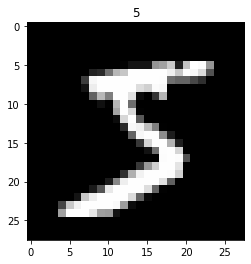

In [ ]:
plt.figure()
plt.imshow(images[0], cmap="Greys_r")
plt.title(labels[0].item())

The above image is a handwritten number 5 with the title plotted its corresponding label.

## Constructing the Optimiser and Loss Function

Now that we have the model and the data, the two other things we need are the loss function (a measure of how well the network does) and the optimiser (this tells the network how to improve based on the value of the loss function). These are built-in to PyTorch so do not need to be implemented from scratch.

We will use the [cross entropy loss function](https://machinelearningmastery.com/cross-entropy-for-machine-learning/) and [stochastic gradient descent](https://medium.com/@divakar_239/stochastic-vs-batch-gradient-descent-8820568eada1) (SGD) with momentum for the optimiser:

- Cross entropy loss (CEL) measures the similarity between two probability distributions. What the network really outputs is how confident it is that the image is a part of each class. This can be interpreted as a discrete probability distribution for the classes. The true target for an image can be thought of in terms of this same probability distribution but the probability will be 1 when it is the correct class and 0 otherwise. Therefore comparing the network's output probability distribution and this probability distribution will give a good measure of performance.

- SGD is a method for function optimisation and works using the gradient of the loss function to guide the parameters in the neural network &mdash; if the gradient is steeper there will be a bigger update to the parameter to look for a better solution. Momentum in this case adds a kind of "acceleration" term to the gradient meaning if the gradient is larger then the optimiser will move the network away from that set of parameters faster but when the gradient is lower, the optimiser will make even smaller changes than regular SGD. This has been found to be really useful since we are optimising in a "gazillion-billion" dimensional space meaning there are plenty of unwelcome holes we can fall down and regular SGD may get stuck here leading to a bad model.

In [ ]:
loss = nn.CrossEntropyLoss()
optimi = optim.SGD(resnet.parameters(), lr=5e-4, momentum=0.9)

Momentum is usually given a value of 0.9 as it has found to be optimal when including momentum in the optimiser, however experimenting with values between 0.85-0.95 can be beneficial.

The ``lr`` keyword argument specified here is known as the *learning rate* of the optmiser. This is a number that multiplies the gradient of the loss function and determines the amplitude of the change applied to the parameters. It is typically a small number, here we have chosen 5e-4.

## Load Data and scale

In [ ]:
unfocused_imgs = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/data/unfocused/*.bmp')]
focused_imgs= [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/data/focused and partially focused/*.bmp')]

In [ ]:
unfocused_imgs_resized=[cv2.resize(image,(512,512)) for image in unfocused_imgs]
focused_imgs_resized=[cv2.resize(image,(512,512)) for image in focused_imgs]

unfocused_imgs_filenames = [file.split("\\")[-1] for file in glob.glob('/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/*.bmp')]
focused_imgs_filenames= [file.split("\\")[-1] for file in glob.glob('/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/focused and partially focused/*.bmp')]

In [ ]:
print(unfocused_imgs_filenames)

['/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18240.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18257.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18244.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18270.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18232.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18268.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18292.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/data/unfocused/JoMg_AB6833_Final_Product_C1_18233.bmp', '/content/drive/My Drive/Paul sandu/Requirement/Thesis stuff/da

In [ ]:
for i,file in enumerate(unfocused_imgs_resized):
    cv2.imwrite('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/data/unfocused_resized_512_bi/'+unfocused_imgs_filenames[i],file)
    
for i,file in enumerate(focused_imgs_resized):
    cv2.imwrite('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/data/focused_resized_512_bi/'+focused_imgs_filenames[i],file)

In [ ]:
len(unfocused_imgs_resized)

1380

## Label data 

In [ ]:
All_images=unfocused_imgs_resized+focused_imgs_resized
A=[0 for file in unfocused_imgs_resized] # 0=unfocused
B=[1 for file in focused_imgs_resized] # 1=focused
All_images_labelled=A+B
All_images = np.array(All_images)
All_images_labelled = np.array(All_images_labelled)

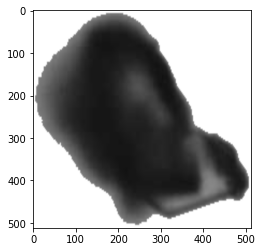

In [ ]:
plt.figure()
plt.imshow(All_images[2], cmap="Greys_r")

## Building the Trainer and Training the Model

The final step is to put all of the four things together and train the model. The model, data, optimiser and loss function are combined in a ``Trainer`` object. These exist in the ``battle_factory`` script mentioned above.

The ``Trainer`` objects combine the model, data, optimiser and loss function into a single object and have the training and validation functions built-in already depending on whether you are doing classification or regression.

Here we will use the ``ClassifierTrainer`` object since we want to train a classification model.

This will be the trickiest bit of coding, since every dataset will be different, we need to create a new ``Trainer`` that inherits from ``ClassifierTrainer``. Inheritance here is an object-oriented programming term that essentially means the new object will have the same properties as the previous object but be able to add more stuff to it &mdash; in this case data loading.

To do this we need to create a [Python class](https://towardsdatascience.com/explaining-python-classes-in-a-simple-way-e3742827c8b5) which is done via the following:

In [ ]:
class ResNetTrainer(ClassifierTrainer):   
    def load_data(self, images, labels):
        indices = np.arange(labels.shape[0])
        np.random.RandomState(seed=12).shuffle(indices)
        max_idx = int(0.8*indices.shape[0])
        
        train_in = images[indices[:max_idx]]
        train_out = labels[indices[:max_idx]]
        print(train_in.shape,train_out.shape)
        # print(train_in[:50].shape)
        train_in = train_in[:50].reshape(50,512*512,3)
        train_out = train_out[:50]
        # print(train_in.shape,train_out.shape)
        val_in = images[indices[max_idx:]]
        val_out = labels[indices[max_idx:]]
        val_in = val_in[:10].reshape(10,512*512,3)
        val_out = val_out[:10]
        print(torch.from_numpy(train_in).unsqueeze(1).float().shape, torch.from_numpy(train_out).long().shape)
        # for i,j in (torch.from_numpy(train_in).unsqueeze(1).float(),torch.from_numpy(train_out).long()):
        #   print(i.shape)
        # print(train_out.int())
        train_set = TensorDataset(torch.from_numpy(train_in).unsqueeze(1).float(), torch.from_numpy(train_out).int())
        val_set = TensorDataset(torch.from_numpy(val_in).unsqueeze(1).float(), torch.from_numpy(val_out).int())
        print(train_set,val_set)
        self.train_loader = DataLoader(train_set, batch_size=self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_set, batch_size=self.batch_size, shuffle=True)
        print(self.train_loader,self.val_loader)
        
    def trainval(self):
        self.training_loss=[]
        self.validation_per=[]
        for n in range(self.total_epochs):
            tl, tp = self.train(train_loader=self.train_loader)
            vl, vp = self.validation(val_loader=self.val_loader)
            self.training_loss.append(tl)
            self.validation_per.append(vp)
            print(f"For epoch {n}, training loss: {tl}, training percentage: {tp}, validation loss: {vl}, validation percentage {vp}")

The above has a bit to unpack so here we go:

- The first line ``class ResNetTrainer(ClassifierTrainer)`` defines a class called ``ResNetTrainer`` and ``ClassifierTrainer`` within the brackets indicates that ``ResNetTrainer`` will inherit from ``ClassifierTrainer``.
- Since our trainer has inherited all of the aspects of ``ClassifierTrainer`` the only function we need to define is how to load the data into the ``Trainer``. This is achieved through defining the ``load_data`` function. A function defined within a class is known as a *class method* and in Python must always take "self" as the first argument to indicate that it is a function within the class.
- The ``load_data`` function will be different for every dataset so here all we need to do is split up the data in [training and validation sets](https://blog.roboflow.com/train-test-split/) since the data was already loaded into memory when it was downloaded.
- The first three lines of this function randomly shuffles the data and defines ``max_idx`` (the maximum index for which data will be included in the training set) as 80% of the total data. The images and labels are then indexed using these shuffled positions to randomly split the dataset into 80% training and 20% validation.
- We then create a ``TensorDataset`` for both the training set and validation set. The ``unsqueeze`` creates a dummy dimension in the images, this is needed since RGB images are technically three dimensional so the grayscale images must be made so too. ``.float()`` ensures that the images are represented by floating point numbers which is required by PyTorch and ``.long()`` ensures that the labels are represented by integers which is also required by PyTorch.
- Lastly, we wrapped the datasets in ``DataLoader`` objects by defining a batch size. The ``DataLoader`` will split up the data into equal sizes of ``batch_size`` and also shuffle the data to make sure the network would not just memorise the training data.

For the ``trainval`` function we create a for loop over the number of epochs of training we want to do and then call on the built-in training and validation functions to perform this. Then there is a line to print the current values of the losses and percentages for the epoch we are on.

The trainer can now be constructed via the following

In [ ]:
resnet_trainer = ResNetTrainer (
    model=resnet,
    optimiser=optimi,
    loss_fn=loss,
    no_of_epochs=5,
    batch_size=16,
    data_pth = "."
)

And the data can be loaded using

In [ ]:
resnet_trainer.load_data(All_images, All_images_labelled)

(1812, 512, 512, 3) (1812,)
torch.Size([50, 1, 262144, 3]) torch.Size([50])
<torch.utils.data.dataset.TensorDataset object at 0x7f6595dc43d0> <torch.utils.data.dataset.TensorDataset object at 0x7f6595eb5f90>
<torch.utils.data.dataloader.DataLoader object at 0x7f659540bbd0> <torch.utils.data.dataloader.DataLoader object at 0x7f6596af1e10>


In [ ]:
np.unique(resnet_trainer.train_loader, return_counts=True)

(array([<torch.utils.data.dataloader.DataLoader object at 0x7f659540bbd0>],
       dtype=object), array([1]))

And trained

In [ ]:
resnet_trainer.trainval()

100%|██████████| 4/4 [00:31<00:00,  7.85s/it]


For epoch 0, training loss: 0.8321467041969299, training percentage: 42.0, validation loss: 0.774346113204956, validation percentage 30.000001907348633


100%|██████████| 4/4 [00:31<00:00,  7.81s/it]


For epoch 1, training loss: 0.6275780200958252, training percentage: 64.0, validation loss: 0.65704345703125, validation percentage 70.0


100%|██████████| 4/4 [00:33<00:00,  8.35s/it]


For epoch 2, training loss: 0.6712424755096436, training percentage: 70.0, validation loss: 0.6258057355880737, validation percentage 70.0


100%|██████████| 4/4 [00:33<00:00,  8.28s/it]


For epoch 3, training loss: 0.4630991518497467, training percentage: 84.0, validation loss: 0.6284764409065247, validation percentage 90.0


100%|██████████| 4/4 [00:33<00:00,  8.31s/it]


For epoch 4, training loss: 0.3903227150440216, training percentage: 88.0, validation loss: 0.6244993209838867, validation percentage 60.000003814697266


In [ ]:
Random_data_model_check = [cv2.imread(file) for file in glob.glob('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/Random Data/*.bmp')]                 
Random_data_model_check_resized=[cv2.resize(image,(512,512)) for image in Random_data_model_check]
Random_data_model_files= [file.split("\\")[-1] for file in glob.glob('/content/drive/MyDrive/Paul sandu/Requirement/Thesis stuff/Random Data/*.bmp')]
Random_images=np.array(Random_data_model_check_resized[:10]).reshape(10,512*512,3)
Random_images_2 = torch.from_numpy(Random_images)
Random_images_3=Random_images_2.float()
Random_images.shape

(10, 262144, 3)

In [ ]:
import torch
torch.cuda.empty_cache()
# import gc
# del variables
# gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 4            |        cudaMalloc retries: 5         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  133662 KB |   12466 MB |     831 GB |     831 GB |\n|       from large pool |  123648 KB |   12456 MB |     831 GB |     831 GB |\n|       from small pool |   10014 KB |      10 MB |       0 GB |       0 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  133662 KB |   12466 MB |     831 GB |     831 GB |\n|       from large pool |  123648 KB |   12456 MB |

In [ ]:
resnet_trainer.model.eval()
with torch.no_grad():
    output=resnet_trainer.model(Random_images_3.unsqueeze(1).cuda())
    output=output.cpu()
    pred_label=torch.argmax(output, axis=1)

In [ ]:
output

tensor([[-0.2021, -0.1634],
        [ 0.0334, -0.0838],
        [-0.0942, -0.0386],
        [-0.0499, -0.1529],
        [ 0.0496, -0.2105],
        [ 0.0783, -0.0868],
        [ 0.0670, -0.1133],
        [-0.1637, -0.2054],
        [-0.1588, -0.2006],
        [-0.0139, -0.1156]])

In [ ]:
# predicted labels for first 10 random images
pred_label

tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# from torchvision import transforms
# resnet_trainer(transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
# resnet_trainer(transform=transforms)

In [ ]:
resnet_trainer.training_loss

[tensor(0.8321),
 tensor(0.6276),
 tensor(0.6712),
 tensor(0.4631),
 tensor(0.3903)]

In [ ]:
resnet_trainer.validation_per

[30.000001907348633, 70.0, 70.0, 90.0, 60.000003814697266]

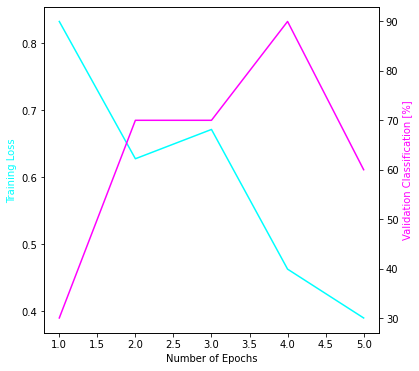

In [ ]:
fig = plt.figure(figsize=(6,6))
train_ax = fig.add_subplot(1,1,1)
val_ax = train_ax.twinx()
# train_ax.set_yscale("log")
train_ax.plot([1,2,3,4,5],resnet_trainer.training_loss,color='cyan')
val_ax.plot([1,2,3,4,5],resnet_trainer.validation_per,color='magenta')
train_ax.set_ylabel("Training Loss", color="cyan")
train_ax.set_xlabel("Number of Epochs")
val_ax.set_ylabel("Validation Classification [%]", color="magenta")
fig.show()
fig.canvas.draw()

In [ ]:
# fig.suptitle(f"Time elapsed {t_now}s after epoch {self.current_epoch}")
train_ax.plot(resnet_trainer.validation_per,[1,2,3,4,5])
train_ax.set_ylabel("Training Loss", color="cyan")
train_ax.set_xlabel("Number of Epochs")
val_ax.set_ylabel("Validation Classification [%]", color="magenta")
fig.show()
# train_ax.semilogy(train_losses, color=pt_vibrant["cyan"], marker="o")
# val_ax.plot(val_losses, color=pt_vibrant["magenta"], marker="o")
# fig.canvas.draw()

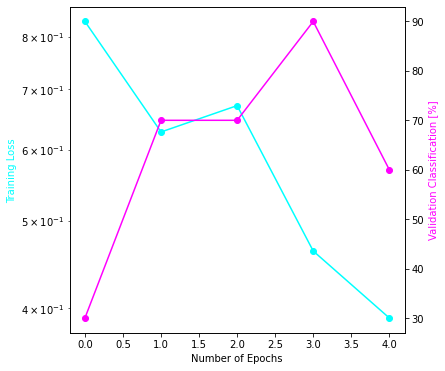

In [ ]:
fig = plt.figure(figsize=(6,6))
train_ax = fig.add_subplot(1,1,1)
val_ax = train_ax.twinx()
#fig.suptitle(f"Time elapsed {t_now}s after epoch {self.current_epoch}")
train_ax.set_ylabel("Training Loss", color="cyan")
train_ax.set_xlabel("Number of Epochs")
val_ax.set_ylabel("Validation Classification [%]", color="magenta")
train_ax.semilogy(resnet_trainer.training_loss, color="cyan", marker="o")
val_ax.plot(resnet_trainer.validation_per, color="magenta", marker="o")
fig.show()
fig.canvas.draw()